I have been averaging the per-TF metrics by ground truth first, then grouping by TF. This makes each of the boxplots show each TF's average score across all ground truths. 

Here, I am testing how averaging the per-TF metrics by TF before grouping by ground truth will look. This will make each of the boxplots show the average per-TF score. I will also try weighting the per-TF averages by how many edges the TF has to see if it makes a difference.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_all_results_auroc_boxplot(df, per_tf=False):
    # 1. Order methods by mean AUROC (highest → lowest)
    method_order = (
        df.groupby("name")["auroc"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # 2. Prepare data in that order
    data = [df.loc[df["name"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention"
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 6))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["name"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

      gt_name                  name     auroc     auprc
0  ChIP-Atlas            CellOracle  0.502296  0.519178
1  ChIP-Atlas                  FigR  0.506698  0.517861
2  ChIP-Atlas                GRaNIE  0.522114  0.530132
3  ChIP-Atlas  Gradient Attribution  0.526148  0.534166
4  ChIP-Atlas                LINGER  0.561540  0.554836


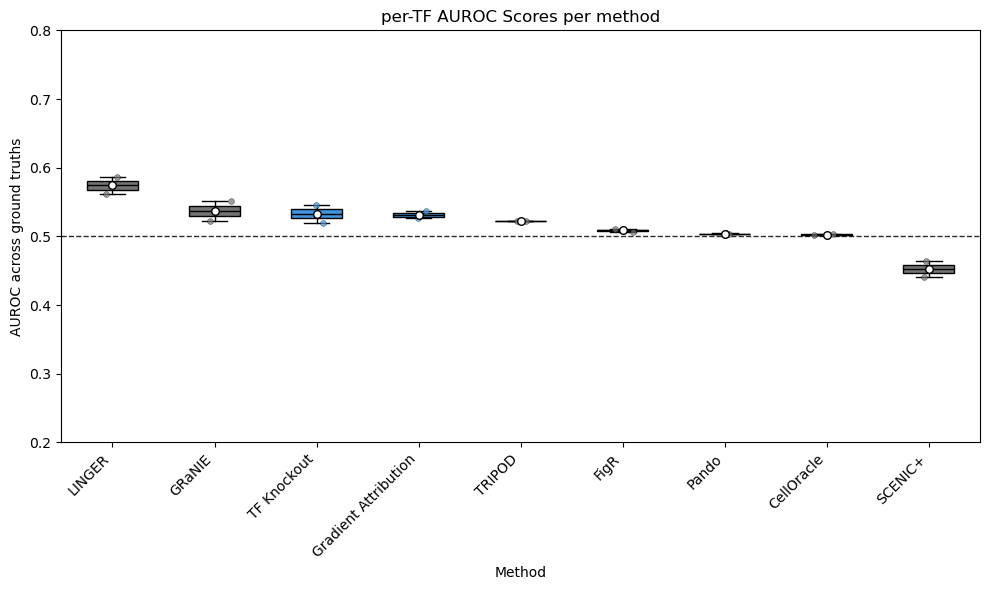

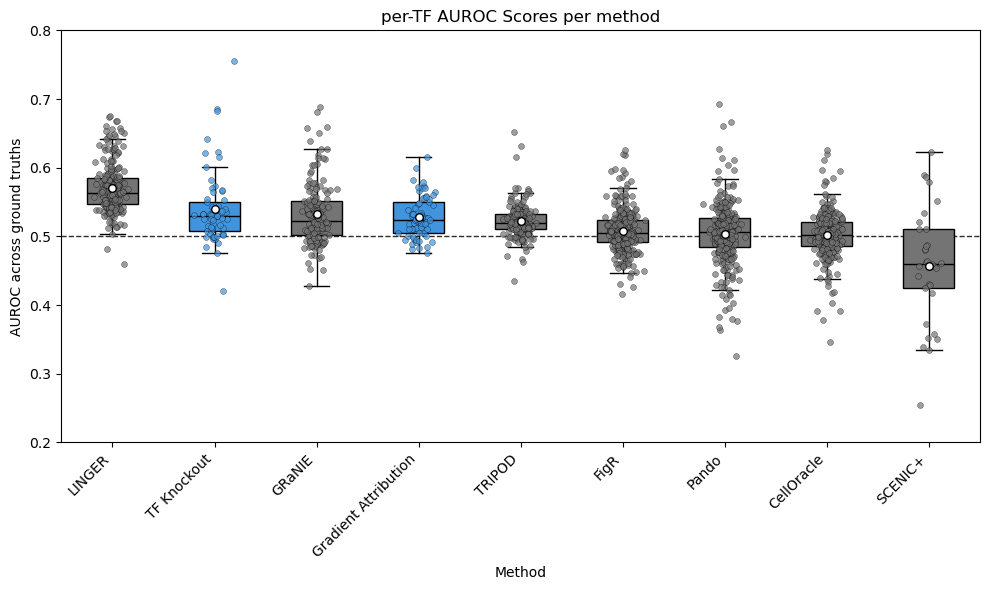

In [39]:
experiment_name = "K562_slow_decay_long_range_two_hop"
experiment_num = "model_training_001"
df = pd.read_csv(f"/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/{experiment_name}/chr19/{experiment_num}/per_tf_auroc_auprc_detailed.csv", header=0, index_col=0)

df = df.copy().rename(columns={"method": "name"})
per_tf_df_agg_by_gt = df.groupby(["gt_name", "name"])[["auroc", "auprc"]].mean().reset_index()
print(per_tf_df_agg_by_gt.head())

agg_by_gt_fig = plot_all_results_auroc_boxplot(per_tf_df_agg_by_gt, per_tf=True)
agg_by_tf_fig = plot_all_results_auroc_boxplot(df, per_tf=True)

agg_by_gt_fig.show()
agg_by_tf_fig.show()